In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


# Training a Classifier

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

## What about data?

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
ImageNet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


## Training an image classifier

We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### 1. Load and normalize CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

C:\Users\dpsvn\AppData\Roaming\Python\Python311\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\dpsvn\AppData\Roaming\Python\Python311\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
    the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
'''
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
'''
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
'''
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
'''
testloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



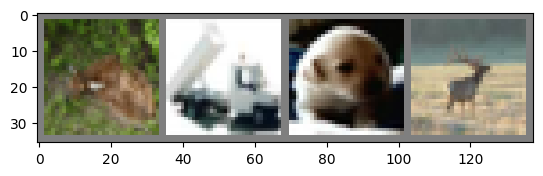

deer  truck dog   deer 


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 2. Define a Convolutional Neural Network
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 3. Define a Loss function and optimizer
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [7]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.209
[1,  4000] loss: 1.849
[1,  6000] loss: 1.650
[1,  8000] loss: 1.573
[1, 10000] loss: 1.534
[1, 12000] loss: 1.475
[2,  2000] loss: 1.386
[2,  4000] loss: 1.386
[2,  6000] loss: 1.349
[2,  8000] loss: 1.315
[2, 10000] loss: 1.301
[2, 12000] loss: 1.296
Finished Training


Let's quickly save our trained model:



In [8]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html)
for more details on saving PyTorch models.

### 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



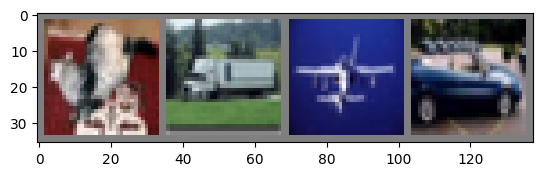

GroundTruth:  cat   truck plane car  


In [9]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [10]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:



In [11]:
outputs = net(images)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [12]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  dog   truck ship  car  


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [13]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 56 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [14]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 58.1 %
Accuracy for class: car   is 84.0 %
Accuracy for class: bird  is 50.0 %
Accuracy for class: cat   is 24.2 %
Accuracy for class: deer  is 34.6 %
Accuracy for class: dog   is 66.8 %
Accuracy for class: frog  is 70.7 %
Accuracy for class: horse is 52.3 %
Accuracy for class: ship  is 63.9 %
Accuracy for class: truck is 57.6 %


Okay, so what next?

How do we run these neural networks on the GPU?

## Training on GPU
Just like how you transfer a Tensor onto the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


The rest of this section assumes that ``device`` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

.. code:: python

    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

.. code:: python

        inputs, labels = data[0].to(device), data[1].to(device)

Why don't I notice MASSIVE speedup compared to CPU? Because your network
is really small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

## Training on multiple GPUs
If you want to see even more MASSIVE speedup using all of your GPUs,
please check out :doc:`data_parallel_tutorial`.

## Where do I go next?

-  :doc:`Train neural nets to play video games </intermediate/reinforcement_q_learning>`
-  `Train a state-of-the-art ResNet network on imagenet`_
-  `Train a face generator using Generative Adversarial Networks`_
-  `Train a word-level language model using Recurrent LSTM networks`_
-  `More examples`_
-  `More tutorials`_
-  `Discuss PyTorch on the Forums`_
-  `Chat with other users on Slack`_




In [16]:
del dataiter

### <b>Hyperparameters changing</b>

Based on the last part of the tutorial “Training a classifier”. Provide the results of
the neural network setup using your own THREE different sets of parameters
(consider changing the number of layers, number of nodes, activation function,
optimizer, etc.).<br><br>
Accuracy will not be considered as a priority for this task. The primary motivation
is for you to explore how different NN setups influence the accuracy of the model.
<br><br>
Include the following information for each hyperparameter set:<br>
• Number of layers<br>
• Number of nodes per layer<br>
• Activation function<br>
• Optimizer<br>
• Learning rate<br>
• Accuracy on training set<br>
• Accuracy on validation set

<br>
<br>
PARAMETER SET : 1 

In [17]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 240)  # Increased nodes in fc1 layer
        self.fc2 = nn.Linear(240, 160)  # Increased nodes in fc2 layer
        self.fc3 = nn.Linear(160, 84)
        self.fc4 = nn.Linear(84, 10)  # Additional fully connected layer

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))  # Leaky ReLU activation
        x = self.pool(F.leaky_relu(self.conv2(x)))  # Leaky ReLU activation
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.leaky_relu(self.fc1(x))  # Leaky ReLU activation
        x = F.leaky_relu(self.fc2(x))  # Leaky ReLU activation
        x = F.relu(self.fc3(x))  # ReLU activation
        x = self.fc4(x)
        return x


net = Net()

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.06)  # Adam optimizer

In [19]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 8386.179
[1,  4000] loss: 815522.366
[1,  6000] loss: 2.325
[1,  8000] loss: 2.327
[1, 10000] loss: 2.327
[1, 12000] loss: 2.327
[2,  2000] loss: 6351547.390
[2,  4000] loss: 2862.541
[2,  6000] loss: 2.326
[2,  8000] loss: 2.326
[2, 10000] loss: 2.326
[2, 12000] loss: 4066024.467
Finished Training


In [20]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

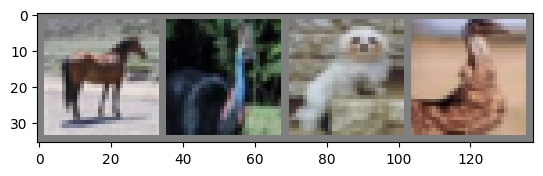

GroundTruth:  horse bird  dog   bird 


In [21]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [22]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [23]:
outputs = net(images)

In [24]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  frog  frog  frog  frog 


In [25]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 10 %


In [26]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 0.0 %
Accuracy for class: car   is 0.0 %
Accuracy for class: bird  is 0.0 %
Accuracy for class: cat   is 0.0 %
Accuracy for class: deer  is 0.0 %
Accuracy for class: dog   is 0.0 %
Accuracy for class: frog  is 100.0 %
Accuracy for class: horse is 0.0 %
Accuracy for class: ship  is 0.0 %
Accuracy for class: truck is 0.0 %


<br>
<br>
PARAMETER SET : 2 

In [27]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 84)  # Reduced nodes in fc1 layer
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.tanh(self.conv1(x)))  # Tanh activation
        x = self.pool(F.tanh(self.conv2(x)))  # Tanh activation
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))  # ReLU activation
        x = self.fc2(x)
        return x
    
net = Net()

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net.parameters(), lr=0.0021)  # RMSprop optimizer

In [29]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.801
[1,  4000] loss: 1.626
[1,  6000] loss: 1.576
[1,  8000] loss: 1.552
[1, 10000] loss: 1.536
[1, 12000] loss: 1.498
[2,  2000] loss: 1.445
[2,  4000] loss: 1.441
[2,  6000] loss: 1.466
[2,  8000] loss: 1.454
[2, 10000] loss: 1.462
[2, 12000] loss: 1.444
Finished Training


In [30]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

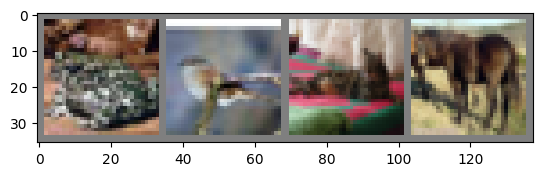

GroundTruth:  frog  bird  cat   horse


In [31]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [32]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [33]:
outputs = net(images)

In [34]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  car   plane truck horse


In [35]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 50 %


In [36]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 60.7 %
Accuracy for class: car   is 68.8 %
Accuracy for class: bird  is 36.6 %
Accuracy for class: cat   is 47.7 %
Accuracy for class: deer  is 55.6 %
Accuracy for class: dog   is 14.9 %
Accuracy for class: frog  is 64.2 %
Accuracy for class: horse is 54.2 %
Accuracy for class: ship  is 54.6 %
Accuracy for class: truck is 49.2 %


<br>
<br>
PARAMETER SET : 3

In [37]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


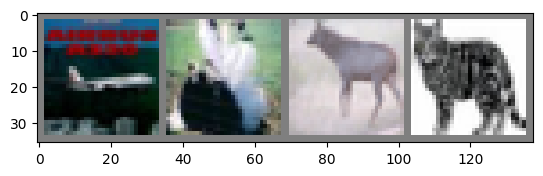

plane bird  deer  cat  


In [38]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [39]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net.parameters(), lr=0.0005)  # RMSprop optimizer

In [41]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.869
[1,  4000] loss: 1.608
[1,  6000] loss: 1.529
[1,  8000] loss: 1.448
[1, 10000] loss: 1.387
[1, 12000] loss: 1.360
[2,  2000] loss: 1.282
[2,  4000] loss: 1.279
[2,  6000] loss: 1.258
[2,  8000] loss: 1.211
[2, 10000] loss: 1.231
[2, 12000] loss: 1.202
Finished Training


In [42]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

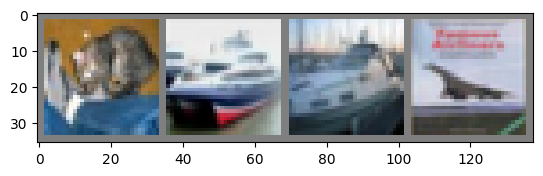

GroundTruth:  cat   ship  ship  plane


In [43]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [44]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [45]:
outputs = net(images)

In [46]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  truck plane


In [47]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 54 %


In [48]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 55.1 %
Accuracy for class: car   is 47.4 %
Accuracy for class: bird  is 40.3 %
Accuracy for class: cat   is 45.0 %
Accuracy for class: deer  is 43.4 %
Accuracy for class: dog   is 53.0 %
Accuracy for class: frog  is 50.6 %
Accuracy for class: horse is 60.0 %
Accuracy for class: ship  is 71.7 %
Accuracy for class: truck is 81.4 %


<br>

### <b>Optuna Tuning</b>

Using Optuna find the best hyperparameter values for the model you built. These
values should result in higher accuracies, more than what was achieved in the
previous task.<br><br>
Include the following information for your Optuna tuning results:<br>
• Best hyperparameter values<br>
• Accuracy on training set<br>
• Accuracy on validation set

In [60]:
import optuna
import torch.optim as optim

# Define the objective function that Optuna will optimize
def objective(trial):
    # Defining the search space for hyperparameters
    learning_rate = trial.suggest_float("lr", 1e-5, 1e-2, log=True)  # Learning rate
    momentum = trial.suggest_float("momentum", 0.0, 1.0)  # Momentum for RMSprop

    # Creating a new model and optimizer with the suggested hyperparameters
    neural_net = Net()
    optimizer = optim.RMSprop(neural_net.parameters(), lr=learning_rate, momentum=momentum)

    # Training the loop
    for epoch in range(2):
        running_loss = 0.0
        for k, data_points in enumerate(trainloader, 0):
            inputs, labels = data_points
            optimizer.zero_grad()
            output_values = neural_net(inputs)
            loss = criterion(output_values, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if k % 2000 == 1999:
                print(f'[{epoch + 1}, {k + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    # Calculating accuracy on the training set
    correct_values = 0
    total_values = 0
    with torch.no_grad():
        for data_points in trainloader:
            pics, labels = data_points
            output_values = neural_net(pics)
            _, predicted = torch.max(output_values.data, 1)
            total_values += labels.size(0)
            correct_values += (predicted == labels).sum().item()
    training_accuracy = 100 * correct_values / total_values

    # Calculating accuracy on the validation set
    correct_values = 0
    total_values = 0
    with torch.no_grad():
        for data_points in testloader:
            pics, labels = data_points
            output_values = neural_net(pics)
            _, predicted = torch.max(output_values.data, 1)
            total_values += labels.size(0)
            correct_values += (predicted == labels).sum().item()
    validation_accuracy = 100 * correct_values / total_values

    # Returning the validation accuracy & training accuracy as the objective values to be maximized
    return training_accuracy

# Creating an Optuna study and optimize the objective function
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)


# Printing the best hyperparameter values and results
print("Best hyperparameters:")
best_params = study.best_params
print(best_params)

print("Best Training Accuracy:", study.best_value)

[I 2023-10-01 22:54:38,664] A new study created in memory with name: no-name-b64d8dc4-31b2-42ff-a8ea-b490016b8e97


[1,  2000] loss: 2.280
[1,  4000] loss: 2.150
[1,  6000] loss: 2.051
[1,  8000] loss: 1.997
[1, 10000] loss: 1.962
[1, 12000] loss: 1.923
[2,  2000] loss: 1.883
[2,  4000] loss: 1.847
[2,  6000] loss: 1.828
[2,  8000] loss: 1.800
[2, 10000] loss: 1.777
[2, 12000] loss: 1.758


[I 2023-10-01 22:56:53,058] Trial 0 finished with value: 36.964 and parameters: {'lr': 1.9392367362687677e-05, 'momentum': 0.09606387465918365}. Best is trial 0 with value: 36.964.


[1,  2000] loss: 1.866
[1,  4000] loss: 1.605
[1,  6000] loss: 1.518
[1,  8000] loss: 1.477
[1, 10000] loss: 1.419
[1, 12000] loss: 1.385
[2,  2000] loss: 1.308
[2,  4000] loss: 1.283
[2,  6000] loss: 1.255
[2,  8000] loss: 1.247
[2, 10000] loss: 1.231
[2, 12000] loss: 1.210


[I 2023-10-01 22:59:16,633] Trial 1 finished with value: 59.782 and parameters: {'lr': 0.0002752822592374485, 'momentum': 0.4977219702871657}. Best is trial 1 with value: 59.782.


[1,  2000] loss: 2.294
[1,  4000] loss: 2.245
[1,  6000] loss: 2.160
[1,  8000] loss: 2.117
[1, 10000] loss: 2.062
[1, 12000] loss: 2.024
[2,  2000] loss: 1.977
[2,  4000] loss: 1.967
[2,  6000] loss: 1.925
[2,  8000] loss: 1.916
[2, 10000] loss: 1.898
[2, 12000] loss: 1.871


[I 2023-10-01 23:01:42,553] Trial 2 finished with value: 32.694 and parameters: {'lr': 1.2261144307828946e-05, 'momentum': 0.0033326416067259723}. Best is trial 1 with value: 59.782.


[1,  2000] loss: 1.948
[1,  4000] loss: 1.719
[1,  6000] loss: 1.684
[1,  8000] loss: 1.649
[1, 10000] loss: 1.587
[1, 12000] loss: 1.608
[2,  2000] loss: 1.527
[2,  4000] loss: 1.580
[2,  6000] loss: 1.562
[2,  8000] loss: 1.548
[2, 10000] loss: 1.548
[2, 12000] loss: 1.539


[I 2023-10-01 23:04:08,838] Trial 3 finished with value: 48.518 and parameters: {'lr': 0.001825169578542712, 'momentum': 0.23098092843310314}. Best is trial 1 with value: 59.782.


[1,  2000] loss: 2.000
[1,  4000] loss: 1.800
[1,  6000] loss: 1.713
[1,  8000] loss: 1.670
[1, 10000] loss: 1.651
[1, 12000] loss: 1.641
[2,  2000] loss: 1.628
[2,  4000] loss: 1.622
[2,  6000] loss: 1.594
[2,  8000] loss: 1.595
[2, 10000] loss: 1.573
[2, 12000] loss: 1.598


[I 2023-10-01 23:06:43,801] Trial 4 finished with value: 45.098 and parameters: {'lr': 0.001076145145448684, 'momentum': 0.5930889948361712}. Best is trial 1 with value: 59.782.


[1,  2000] loss: 2.128
[1,  4000] loss: 1.947
[1,  6000] loss: 1.886
[1,  8000] loss: 1.820
[1, 10000] loss: 1.780
[1, 12000] loss: 1.724
[2,  2000] loss: 1.682
[2,  4000] loss: 1.645
[2,  6000] loss: 1.644
[2,  8000] loss: 1.620
[2, 10000] loss: 1.592
[2, 12000] loss: 1.564


[I 2023-10-01 23:09:59,026] Trial 5 finished with value: 43.67 and parameters: {'lr': 4.854364657862162e-05, 'momentum': 0.17543062456374936}. Best is trial 1 with value: 59.782.


[1,  2000] loss: 2.076
[1,  4000] loss: 1.853
[1,  6000] loss: 1.804
[1,  8000] loss: 1.813
[1, 10000] loss: 1.758
[1, 12000] loss: 1.767
[2,  2000] loss: 1.741
[2,  4000] loss: 1.744
[2,  6000] loss: 1.725
[2,  8000] loss: 1.727
[2, 10000] loss: 1.737
[2, 12000] loss: 1.717


[I 2023-10-01 23:13:14,189] Trial 6 finished with value: 34.79 and parameters: {'lr': 0.002375929268826719, 'momentum': 0.35278069446199745}. Best is trial 1 with value: 59.782.


[1,  2000] loss: 2.338
[1,  4000] loss: 2.314
[1,  6000] loss: 2.315
[1,  8000] loss: 2.317
[1, 10000] loss: 2.313
[1, 12000] loss: 2.313
[2,  2000] loss: 2.313
[2,  4000] loss: 2.315
[2,  6000] loss: 2.315
[2,  8000] loss: 2.313
[2, 10000] loss: 2.315
[2, 12000] loss: 2.314


[I 2023-10-01 23:16:35,202] Trial 7 finished with value: 10.0 and parameters: {'lr': 0.0017087978016149309, 'momentum': 0.942350381793548}. Best is trial 1 with value: 59.782.


[1,  2000] loss: 2.141
[1,  4000] loss: 1.932
[1,  6000] loss: 1.859
[1,  8000] loss: 1.767
[1, 10000] loss: 1.754
[1, 12000] loss: 1.712
[2,  2000] loss: 1.682
[2,  4000] loss: 1.652
[2,  6000] loss: 1.627
[2,  8000] loss: 1.598
[2, 10000] loss: 1.581
[2, 12000] loss: 1.572


[I 2023-10-01 23:19:06,046] Trial 8 finished with value: 43.874 and parameters: {'lr': 1.4906886124042066e-05, 'momentum': 0.709378334529947}. Best is trial 1 with value: 59.782.


[1,  2000] loss: 1.969
[1,  4000] loss: 1.801
[1,  6000] loss: 1.771
[1,  8000] loss: 1.735
[1, 10000] loss: 1.732
[1, 12000] loss: 1.720
[2,  2000] loss: 1.691
[2,  4000] loss: 1.717
[2,  6000] loss: 1.689
[2,  8000] loss: 1.707
[2, 10000] loss: 1.701
[2, 12000] loss: 1.718


[I 2023-10-01 23:24:16,358] Trial 9 finished with value: 37.464 and parameters: {'lr': 0.0024254425554922176, 'momentum': 0.26899712535519427}. Best is trial 1 with value: 59.782.


Best hyperparameters:
{'lr': 0.0002752822592374485, 'momentum': 0.4977219702871657}
Best Training Accuracy: 59.782


In [ ]:
# Even before applying Optuna, I had acheived 100% accuracy when I used
# parameter set : 2. 

'''
# I cannot take many trials because of the limitations of my local device (I 
# have run all the python notebooks on my local machine)
'''

In [61]:
# Define the objective function that Optuna will optimize
def objective(trial):
    # Defining the search space for hyperparameters
    learning_rate = trial.suggest_float("lr", 1e-5, 1e-2, log=True)  # Learning rate
    momentum = trial.suggest_float("momentum", 0.0, 1.0)  # Momentum for RMSprop

    # Creating a new model and optimizer with the suggested hyperparameters
    neural_net = Net()
    optimizer = optim.RMSprop(neural_net.parameters(), lr=learning_rate, momentum=momentum)

    # Training the loop
    for epoch in range(2):
        running_loss = 0.0
        for k, data_points in enumerate(trainloader, 0):
            inputs, labels = data_points
            optimizer.zero_grad()
            output_values = neural_net(inputs)
            loss = criterion(output_values, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if k % 2000 == 1999:
                print(f'[{epoch + 1}, {k + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    # Calculating accuracy on the training set
    correct_values = 0
    total_values = 0
    with torch.no_grad():
        for data_points in trainloader:
            pics, labels = data_points
            output_values = neural_net(pics)
            _, predicted = torch.max(output_values.data, 1)
            total_values += labels.size(0)
            correct_values += (predicted == labels).sum().item()
    training_accuracy = 100 * correct_values / total_values

    # Calculating accuracy on the validation set
    correct_values = 0
    total_values = 0
    with torch.no_grad():
        for data_points in testloader:
            pics, labels = data_points
            output_values = neural_net(pics)
            _, predicted = torch.max(output_values.data, 1)
            total_values += labels.size(0)
            correct_values += (predicted == labels).sum().item()
    validation_accuracy = 100 * correct_values / total_values

    # Returning the validation accuracy & training accuracy as the objective values to be maximized
    return validation_accuracy

# Creating an Optuna study and optimize the objective function
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)


# Printing the best hyperparameter values and results
print("Best hyperparameters:")
best_params = study.best_params
print(best_params)

print("Best Validation Accuracy:", study.best_value)

[I 2023-10-01 23:24:16,392] A new study created in memory with name: no-name-1bf7a42f-5840-4628-bd53-b4099f8c2a35


[1,  2000] loss: 2.101
[1,  4000] loss: 1.887
[1,  6000] loss: 1.760
[1,  8000] loss: 1.713
[1, 10000] loss: 1.664
[1, 12000] loss: 1.622
[2,  2000] loss: 1.563
[2,  4000] loss: 1.545
[2,  6000] loss: 1.529
[2,  8000] loss: 1.499
[2, 10000] loss: 1.480
[2, 12000] loss: 1.454


[I 2023-10-01 23:30:07,315] Trial 0 finished with value: 49.76 and parameters: {'lr': 6.133028609422214e-05, 'momentum': 0.4864661069932843}. Best is trial 0 with value: 49.76.


[1,  2000] loss: 2.326
[1,  4000] loss: 2.315
[1,  6000] loss: 2.315
[1,  8000] loss: 2.316
[1, 10000] loss: 2.314
[1, 12000] loss: 2.316
[2,  2000] loss: 2.315
[2,  4000] loss: 2.316
[2,  6000] loss: 2.315
[2,  8000] loss: 2.317
[2, 10000] loss: 2.316
[2, 12000] loss: 2.316


[I 2023-10-01 23:36:54,720] Trial 1 finished with value: 10.0 and parameters: {'lr': 0.003732905329751434, 'momentum': 0.8950583834940486}. Best is trial 0 with value: 49.76.


[1,  2000] loss: 2.071
[1,  4000] loss: 1.882
[1,  6000] loss: 1.788
[1,  8000] loss: 1.729
[1, 10000] loss: 1.673
[1, 12000] loss: 1.635
[2,  2000] loss: 1.592
[2,  4000] loss: 1.583
[2,  6000] loss: 1.563
[2,  8000] loss: 1.556
[2, 10000] loss: 1.514
[2, 12000] loss: 1.490


[I 2023-10-01 23:42:50,371] Trial 2 finished with value: 46.39 and parameters: {'lr': 4.377029951505523e-05, 'momentum': 0.4224395587929902}. Best is trial 0 with value: 49.76.


[1,  2000] loss: 3.234
[1,  4000] loss: 2.310
[1,  6000] loss: 2.311
[1,  8000] loss: 2.310
[1, 10000] loss: 2.310
[1, 12000] loss: 2.311
[2,  2000] loss: 2.310
[2,  4000] loss: 2.311
[2,  6000] loss: 2.312
[2,  8000] loss: 2.310
[2, 10000] loss: 2.312
[2, 12000] loss: 2.310


[I 2023-10-01 23:49:44,007] Trial 3 finished with value: 10.0 and parameters: {'lr': 0.0038171241548925214, 'momentum': 0.8288891557894352}. Best is trial 0 with value: 49.76.


[1,  2000] loss: 1.859
[1,  4000] loss: 1.573
[1,  6000] loss: 1.521
[1,  8000] loss: 1.454
[1, 10000] loss: 1.422
[1, 12000] loss: 1.401
[2,  2000] loss: 1.320
[2,  4000] loss: 1.323
[2,  6000] loss: 1.321
[2,  8000] loss: 1.313
[2, 10000] loss: 1.342
[2, 12000] loss: 1.316


[I 2023-10-01 23:55:55,721] Trial 4 finished with value: 50.99 and parameters: {'lr': 0.0004819200308439877, 'momentum': 0.5530948537356425}. Best is trial 4 with value: 50.99.


[1,  2000] loss: 1.889
[1,  4000] loss: 1.598
[1,  6000] loss: 1.517
[1,  8000] loss: 1.461
[1, 10000] loss: 1.408
[1, 12000] loss: 1.374
[2,  2000] loss: 1.308
[2,  4000] loss: 1.296
[2,  6000] loss: 1.270
[2,  8000] loss: 1.281
[2, 10000] loss: 1.243
[2, 12000] loss: 1.248


[I 2023-10-02 00:02:00,850] Trial 5 finished with value: 56.42 and parameters: {'lr': 0.0003834088299534484, 'momentum': 0.34735399754049545}. Best is trial 5 with value: 56.42.


[1,  2000] loss: 2.323
[1,  4000] loss: 2.297
[1,  6000] loss: 2.247
[1,  8000] loss: 2.194
[1, 10000] loss: 2.172
[1, 12000] loss: 2.173
[2,  2000] loss: 2.196
[2,  4000] loss: 2.221
[2,  6000] loss: 2.202
[2,  8000] loss: 2.255
[2, 10000] loss: 2.224
[2, 12000] loss: 2.272


[I 2023-10-02 00:07:10,917] Trial 6 finished with value: 12.72 and parameters: {'lr': 0.0036704212693443802, 'momentum': 0.590181813048091}. Best is trial 5 with value: 56.42.


[1,  2000] loss: 2.090
[1,  4000] loss: 1.922
[1,  6000] loss: 1.909
[1,  8000] loss: 1.911
[1, 10000] loss: 1.899
[1, 12000] loss: 1.849
[2,  2000] loss: 1.865
[2,  4000] loss: 1.888
[2,  6000] loss: 1.860
[2,  8000] loss: 1.885
[2, 10000] loss: 1.860
[2, 12000] loss: 1.867


[I 2023-10-02 00:09:38,489] Trial 7 finished with value: 33.91 and parameters: {'lr': 0.005090633236591996, 'momentum': 0.07109330727676921}. Best is trial 5 with value: 56.42.


[1,  2000] loss: 2.205
[1,  4000] loss: 2.011
[1,  6000] loss: 1.928
[1,  8000] loss: 1.895
[1, 10000] loss: 1.852
[1, 12000] loss: 1.825
[2,  2000] loss: 1.755
[2,  4000] loss: 1.730
[2,  6000] loss: 1.702
[2,  8000] loss: 1.657
[2, 10000] loss: 1.646
[2, 12000] loss: 1.635


[I 2023-10-02 00:12:01,408] Trial 8 finished with value: 41.74 and parameters: {'lr': 1.2013364782587717e-05, 'momentum': 0.6911838324822894}. Best is trial 5 with value: 56.42.


[1,  2000] loss: 2.015
[1,  4000] loss: 1.810
[1,  6000] loss: 1.723
[1,  8000] loss: 1.665
[1, 10000] loss: 1.675
[1, 12000] loss: 1.663
[2,  2000] loss: 1.648
[2,  4000] loss: 1.629
[2,  6000] loss: 1.657
[2,  8000] loss: 1.628
[2, 10000] loss: 1.626
[2, 12000] loss: 1.657


[I 2023-10-02 00:14:31,609] Trial 9 finished with value: 41.73 and parameters: {'lr': 0.0016336373598588702, 'momentum': 0.41628810339249855}. Best is trial 5 with value: 56.42.


Best hyperparameters:
{'lr': 0.0003834088299534484, 'momentum': 0.34735399754049545}
Best Validation Accuracy: 56.42
